In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/identifying-disease-in-tea-leafs
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/Anthracnose
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/healthy
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/bird eye spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/brown blight
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/red leaf spot
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/gray light
/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/algal leaf


In [46]:
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3

## Image sample

In [35]:
image = cv.imread("/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/white spot/UNADJUSTEDNONRAW_thumb_100.jpg")
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

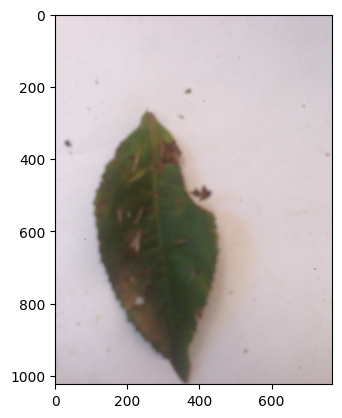

(1024, 768, 3)


In [36]:
plt.imshow(image_rgb)
plt.show()
print(image.shape)

## Data preprocessing 

In [37]:
path = "/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset"

train,test = tf.keras.utils.image_dataset_from_directory(
    path,
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    seed=42,
    batch_size=32,
    image_size=(500, 500),
)

train=train.cache().prefetch(1).shuffle(100)
test=test.cache().prefetch(1)

Found 885 files belonging to 8 classes.
Using 708 files for training.
Using 177 files for validation.


## Pre trained base model (EfficientNetV2B3)

In [38]:
base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(500,500,3))
base_model.trainable = False

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Output layers configuration

In [39]:
# Base model output
base_out = base_model.output

# Configure our custom output layer
x = Flatten()(base_out)
x = Dense(512, activation='relu')(x)
x = Dense(8, activation='softmax')(x)

# Create final model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

## Compiling and training

In [40]:
model.compile(
    optimizer='Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [41]:
es=EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)
lr=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-10,
)

In [42]:
model.fit(
    train,
    epochs=30,
    validation_data=test,
    callbacks=[es, lr]
)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.3831 - loss: 104.8249 - val_accuracy: 0.7175 - val_loss: 15.6941 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.8436 - loss: 6.5895 - val_accuracy: 0.7232 - val_loss: 17.1805 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step - accuracy: 0.8805 - loss: 4.3855 - val_accuracy: 0.7966 - val_loss: 8.7768 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.9477 - loss: 1.6587 - val_accuracy: 0.8531 - val_loss: 7.6694 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.9671 - loss: 0.8405 - val_accuracy: 0.8079 - val_loss: 8.3142 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.9449 - loss: 1.6761 - val_accuracy: 0.7853 - val_loss: 9.7854 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.9573 - loss: 1.0653

## Confusion matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step


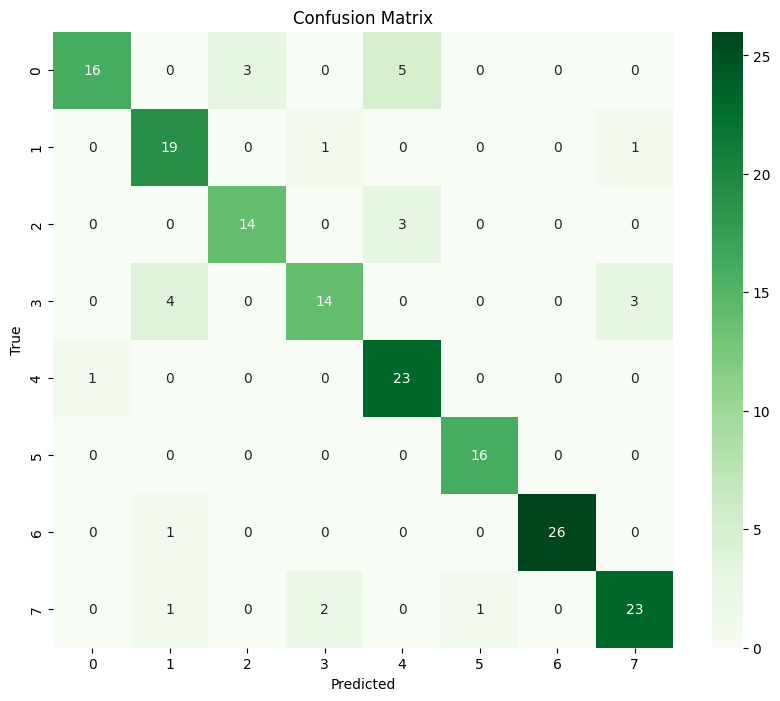

In [45]:
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = []
for images, labels in test:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)


cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## F1- Score

In [51]:
score = f1_score(y_true, y_pred_classes, average='micro')
print(score)

0.8531073446327684


# Achieved F1 Score is: 0.853